<a href="https://colab.research.google.com/github/Sushmitha-Katti/Monocular-Depth-Estimation-and-Segmentation/blob/master/Depth/Depth_RMSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Check GPU type

In [0]:
! nvidia-smi

Mon May 25 06:51:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    33W / 250W |   2343MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Mount Colab

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


## UNet

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [0]:
import torch.nn.functional as F



class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
      # ---------- Depth ------------------
        self.inc = DoubleConv(n_channels, 32)
        self.down1_depth = Down(32, 32)
        self.down2_depth = Down(32, 64)
        self.down3_depth = Down(64, 128)
        self.down4_depth = Down(128, 256)

        factor = 2 if bilinear else 1

        self.down5_depth = Down(256, 512 // factor)
        self.up1_depth = Up(512, 256 // factor, bilinear)
        self.up2_depth = Up(256, 128 // factor, bilinear)
        self.up3_depth = Up(128, 64 // factor, bilinear)
        self.up4_depth = Up(64, 32 , bilinear)
        self.up5_depth = Up(64, 32, bilinear)
        self.outc_depth = OutConv(32, n_classes)

      # -------------- Mask -------------------
        self.down1_mask = Down(32, 64)
        self.down2_mask = Down(64, 128)
        self.down3_mask = Down(128, 256)

        factor = 2 if bilinear else 1

        self.down4_mask = Down(256, 512 // factor)
        self.up1_mask = Up(512, 256 // factor, bilinear)
        self.up2_mask = Up(256, 128 // factor, bilinear)
        self.up3_mask = Up(128, 64 // factor, bilinear)
        self.up4_mask = Up(64, 32, bilinear)
        self.outc_mask = OutConv(32, n_classes)

    def forward(self, inputimg):
        # -------- Same to both mask and depth ----------------

        x1 = self.inc(inputimg)

        # ----------Depth-----------
      
        x2_depth = self.down1_depth(x1)
        x3_depth = self.down2_depth(x2_depth)
        x4_depth = self.down3_depth(x3_depth)
        x5_depth = self.down4_depth(x4_depth)
        x6_depth = self.down5_depth(x5_depth)
      
        x_depth = self.up1_depth(x6_depth, x5_depth)
        x_depth = self.up2_depth(x_depth, x4_depth)
        x_depth = self.up3_depth(x_depth, x3_depth)
        x_depth = self.up4_depth(x_depth, x2_depth)
        x_depth = self.up5_depth(x_depth, x1)
        
        logits_depth = self.outc_mask(x_depth)
    
        return  logits_depth

## Model Summary

In [0]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = UNet(n_channels = 6,n_classes = 1).to(device)
summary(model, input_size=(6, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]           1,760
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           9,248
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              ReLU-6           [-1, 32, 64, 64]               0
        DoubleConv-7           [-1, 32, 64, 64]               0
         MaxPool2d-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           9,248
      BatchNorm2d-10           [-1, 32, 32, 32]              64
             ReLU-11           [-1, 32, 32, 32]               0
           Conv2d-12           [-1, 32, 32, 32]           9,248
      BatchNorm2d-13           [-1, 32, 32, 32]              64
             ReLU-14           [-1, 32,

## Extract

In [0]:
#Extract data
import time
import os
import zipfile
if (os.path.isdir("data_1")):
    print ('Images already downloaded...')
else:
  start = time.time()
  archive = zipfile.ZipFile(f'/content/gdrive/My Drive/Mask_Rcnn/Dataset/data_part1.zip')
  archive.extractall()
  end = time.time()
  print(f"data set extraction took {round(end-start,2)}s")

data set extraction took 31.67s


## Clone Pynet

In [0]:
!git clone "https://github.com/Sushmitha-Katti/PyTNet"

fatal: destination path 'PyTNet' already exists and is not an empty directory.


## Albumentation installation

In [0]:
!pip install --no-cache-dir git+https://github.com/albu/albumentations > /dev/null && echo "Albumentation library is successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-3bjrxguz
Albumentation library is successfully installed!


In [0]:
import sys
sys.path.append("PyTNet")

## Import Statement

In [0]:
import torch
import train_test_loader
import show_images

import evaluate
from Albumentationtransform import AlbumentationTransforms

## Dataset

In [0]:
from torch.utils.data import Dataset, random_split
import math
from PIL import Image
import numpy as np
import torch
import os
from tqdm import notebook
# -----------------------------------------------------Main Function which calls everything--------------------------------------------------------------
def RawDataSet(train_split = 70,test_transforms = None,train_transforms = None, set_no=1, url_path ='None', whole_data = True ):

  dataset = Rawdata(url=url_path,set_no = set_no, whole_data = whole_data )
  train_len = len(dataset)*train_split//100
  test_len = len(dataset) - train_len 
  print(len(dataset))
  train_set, val_set = random_split(dataset, [train_len, test_len])
  train_dataset = DatasetFromSubset(train_set, transform=train_transforms)
  test_dataset = DatasetFromSubset(val_set, transform=train_transforms)
  del dataset
  del train_len
  del test_len
  del train_set
  del val_set
  
  return train_dataset, test_dataset



# --------------------------------------------------------------Custom data set-------------------------------------------------------------------------

class Rawdata(Dataset):
    def __init__(self,url, set_no, whole_data):
        self.fg_bg = []
        self.depth = []
        self.bg = []
        self.url = url
        self.mask = []
        
        if(whole_data):

          for set_no in range(1,6):
            pref_url = '/content/data_'+str(set_no)
            for i in notebook.tqdm(range(80000)):
            
              self.fg_bg.append(f'{pref_url}/Fg-Bg/fg-bg{str(i+1 + (set_no-1)*80000)}.jpg')  
              self.bg.append(math.ceil((i+1)/800)) #80k images spanned over 100 bg's. Means 800 images per background
              self.depth.append(f'{pref_url}/Depth/depth{str(i+1 + (set_no-1)*80000)}.jpg')
              self.mask.append(f'{pref_url}/Fg-Bg-Mask/fg-bg-mask{str(i+1 + (set_no-1)*80000)}.jpg')

      
        else:
            for i in notebook.tqdm(range(80000)):
              
              self.fg_bg.append(f'{url}/Fg-Bg/fg-bg{str(i+1 + (set_no-1)*80000)}.jpg')  
              self.bg.append(math.ceil((i+1)/800)) #80k images spanned over 100 bg's. Means 800 images per background
              self.depth.append(f'{url}/Depth/depth{str(i+1 + (set_no-1)*80000)}.jpg')
              self.mask.append(f'{url}/Fg-Bg-Mask/fg-bg-mask{str(i+1 + (set_no-1)*80000)}.jpg')
       
            
    def __len__(self):
        return len(self.fg_bg)

    def __getitem__(self, idx):
        fg_bg = self.fg_bg[idx]
        depth = self.depth[idx]
        bg = self.bg[idx]
        mask = self.mask[idx]
        return fg_bg,bg,mask,depth



# ----------------------------------------------------Data subset which comes after splitting--------------------------------------------------

class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        

    def __getitem__(self, index):
        fg_bg,bg,mask,depth = self.subset[index]
        
       
        fg_bg=cv2.imread(fg_bg)[:, :, [2, 1, 0]]
        
        bg = cv2.imread(f"/content/gdrive/My Drive/Mask_Rcnn/Background/bg{str(bg)}.jpg")[:, :, [2, 1, 0]]
        #print(fg_bg,bg)
        inputimg = np.concatenate((bg,fg_bg ), axis=2)
        mask = cv2.imread(mask,cv2.IMREAD_GRAYSCALE)
        depth = cv2.imread(depth,cv2.IMREAD_GRAYSCALE)
        
        
        


        if self.transform:

            #print(transform)
            inputimg = self.transform['ip'](inputimg)
            mask = self.transform['op'](mask)
            depth = self.transform['op'](depth)
        return inputimg, mask,depth

    def __len__(self):
        return len(self.subset)

# -------------------------------------------------------------------------------------------------------------------------------------------------------







## Dataloader and Albumentation

In [0]:
import albumentations as A
import cv2
import time
fg_bg_means = (0.65830478, 0.61511271, 0.5740604,0.65830478, 0.61511271, 0.5740604)
fg_bg_stdevs = (0.24408717, 0.2542491, 0.26870159,0.24408717, 0.2542491, 0.26870159)
op_means = (0)
op_std = (255)

train_transform = AlbumentationTransforms([       
                                                                
                             
                                      A.Resize(64,64),
                                      A.Normalize(mean=fg_bg_means, std=fg_bg_stdevs),
                                   
                                       ])
op_transform = AlbumentationTransforms([       
                                                                
                             
                                      A.Resize(64,64),
                                      A.Normalize(mean=op_means, std=op_std),
                                      A.Transpose(always_apply=True),
                                
                                   
                                       ])

test_transform = AlbumentationTransforms([
                                          A.Resize(64,64),
                                          A.Normalize(mean=fg_bg_means, std=fg_bg_stdevs),
                                        ])
train  = {
    'ip': train_transform,
    'op': op_transform
}
test = {
    'ip': test_transform,
    'op': op_transform
}
start = time.time()
train_dataset , test_dataset= RawDataSet(train_split = 70,test_transforms=test,train_transforms=train, set_no = 1, whole_data = False, url_path = "/content/data_1")
end = time.time()
print(f'dataset formation took {round(end-start,3)} seconds')


80000
dataset formation took 0.185 seconds


In [0]:
trainloader, testloader = train_test_loader.load(train_dataset,test_dataset,batch_size=128)

In [0]:
import torchvision
from torch.utils.tensorboard import SummaryWriter
tb = SummaryWriter('runs/MODEST-Depth')
images, mask, depth = next(iter(trainloader))
images = images.to(device)

#tb.add_image('images', images)
tb.add_graph(model, images)
tb.close()

In [0]:
tb.flush()

In [0]:
import os
logs_base_dir = "runs/MODEST-Depth"
os.makedirs(logs_base_dir, exist_ok=True)

In [0]:
tb.flush()

In [0]:
%reload_ext tensorboard
%tensorboard --logdir {logs_base_dir}

Reusing TensorBoard on port 6006 (pid 2307), started 1:38:51 ago. (Use '!kill 2307' to kill it.)

<IPython.core.display.Javascript object>

# Sample Inputs

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import time


# functions to show an image
def imshow(img,c, gray = False ):
  fig = plt.figure(figsize=(40,40))
 
  if(gray):
      img = img*255
      npimg = img.numpy()
      
      plt.imshow(npimg[0],interpolation='none', cmap = "gray")
      
  else : 
      img = img * 0.2 + 0.6     # unnormalize
      npimg = img.numpy()
  
      plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='none')
  plt.axis("off")

  plt.title(c,fontweight="bold",fontsize=35)



def show_sample_data(dataset):

	# get some random training images
  start = time.time()
  dataiter = iter(dataset)
  images, mask,depth = dataiter.next()  
  bg = [images[i][:3] for i in range(10) ]
  fg_bg = [images[i][3:] for i in range(10)   ]
  m = torch.unsqueeze(mask, 1)
  d = torch.unsqueeze(depth, 1)
  masks = [m[i] for i in range(10) ]
  depths = [d[i] for i in range(10) ]
  imshow(torchvision.utils.make_grid(bg,nrow=10,padding=1,scale_each=True), "bg")
  imshow(torchvision.utils.make_grid(fg_bg,nrow=10,padding=1,scale_each=True), "fg_bg")
  imshow(torchvision.utils.make_grid(masks,nrow=10,padding=1,scale_each=True), "mask", gray = True)
  imshow(torchvision.utils.make_grid(depths,nrow=10,padding=1,scale_each=True), "depth", gray = True)
  end = time.time()
  print(f"sample train images took {round((end - start),3)}s to dispay")

sample train images took 1.406s to dispay


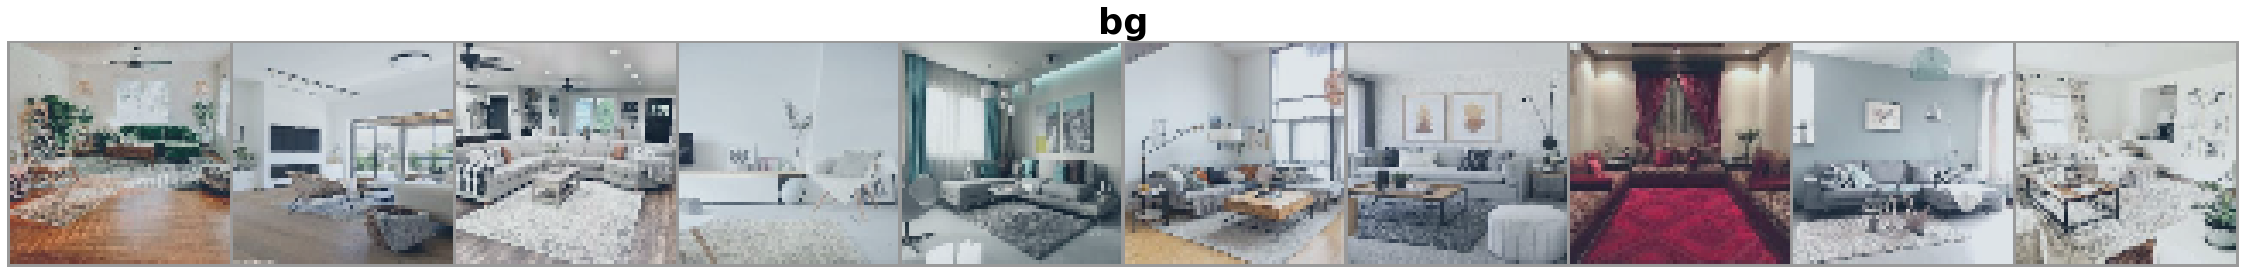

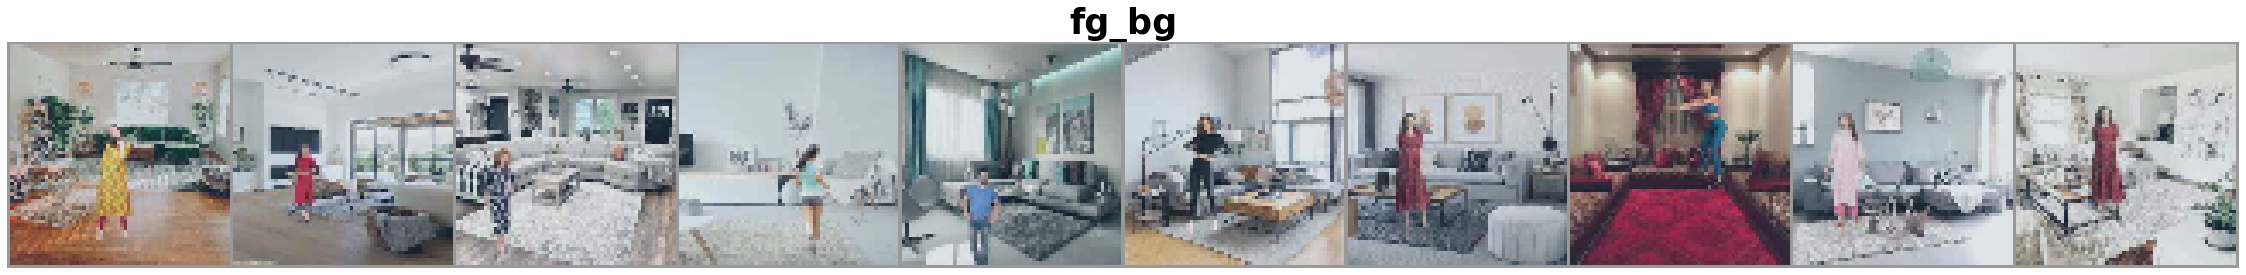

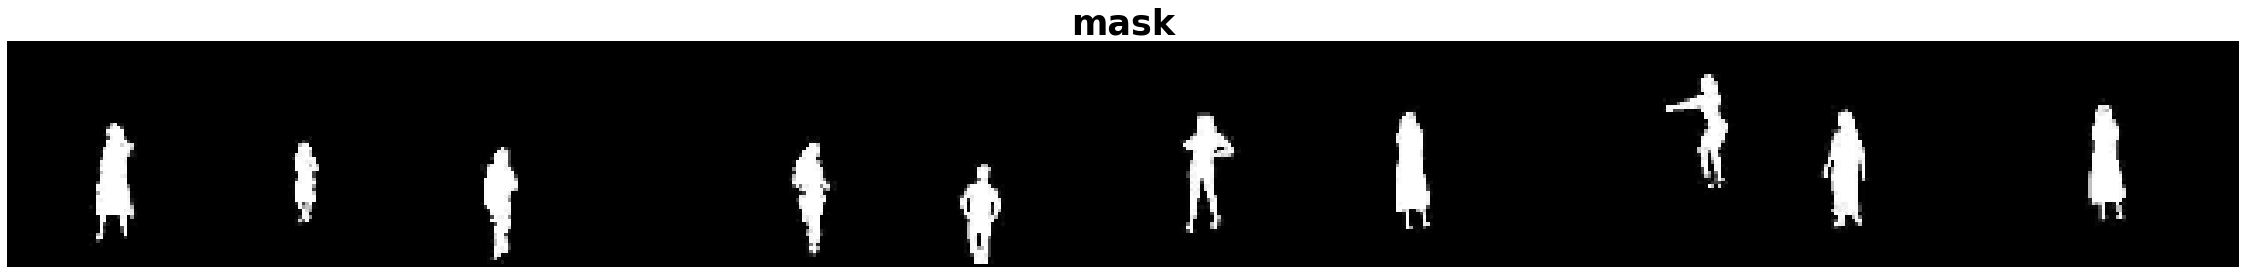

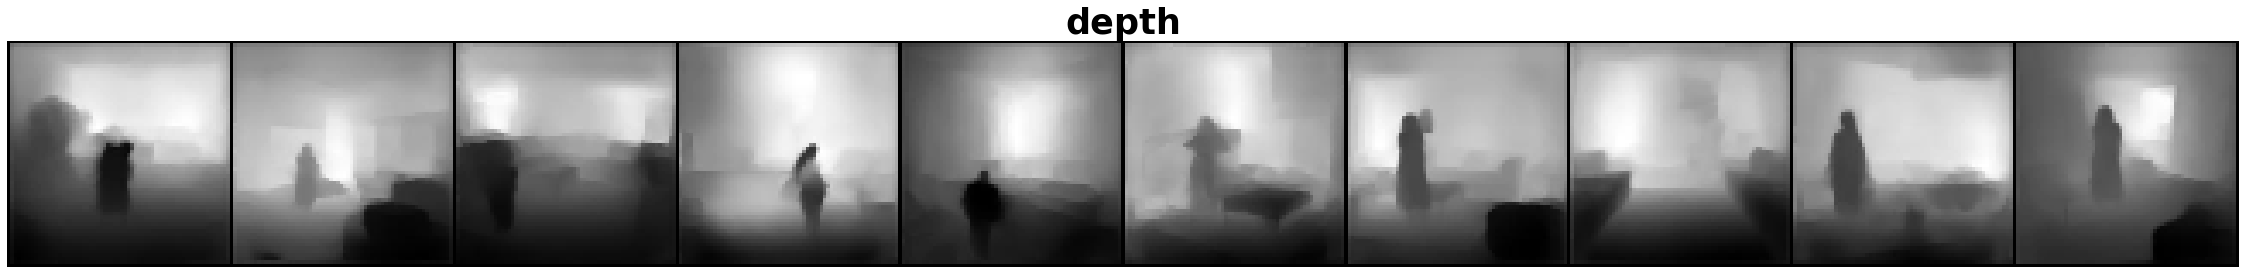

In [0]:
show_sample_data(trainloader)

# Model Training

In [0]:
import torch
from torch.autograd import Function


class DiceCoeff(Function):
    """Dice coeff for individual examples"""

    def forward(self, input, target):
        self.save_for_backward(input, target)
        eps = 0.0001
        self.inter = torch.dot(input.view(-1), target.view(-1))
        self.union = torch.sum(input) + torch.sum(target) + eps

        t = (2 * self.inter.float() + eps) / self.union.float()
        return t

    # This function has only a single output, so it gets only one gradient
    def backward(self, grad_output):

        input, target = self.saved_variables
        grad_input = grad_target = None

        if self.needs_input_grad[0]:
            grad_input = grad_output * 2 * (target * self.union - self.inter) \
                         / (self.union * self.union)
        if self.needs_input_grad[1]:
            grad_target = None

        return grad_input, grad_target


def dice_coefficient(pred, target, mask=False):
    """Dice coeff for batches"""
    pred = torch.sigmoid(pred)
    s = torch.FloatTensor(1).cuda().zero_()

    for i, c in enumerate(zip(pred, target)):
        s = s + DiceCoeff().forward(c[0], c[1])

    return s / (i + 1)

In [0]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [0]:

"""train_test.py

train_test for mask and depth

"""


import dill as dill
import torch
import time

#Training & Testing Loops
from tqdm.notebook import tqdm
from tqdm import tqdm_notebook

train_losses = []
test_losses = []
train_acc = []
test_acc = []
running_mask_loss=0.0
running_depth_loss=0.0

def train(model, device, train_loader, optimizer, depth_criterion, epoch,scheduler = False):
  running_mask_loss = 0.0
  running_depth_loss=0.0
  model.train()
  mask_coef = 0
  depth_coef = 0
  pbar = tqdm(train_loader)
  total_length = len(train_loader)
  for batch_idx, (data, mask_target, depth_target) in enumerate(pbar):
    # get samples
    data,  depth_target = data.to(device), depth_target.to(device)


    optimizer.zero_grad()

    depth_target = depth_target.unsqueeze_(1)
    depth_pred = model(data)

    depth_loss = depth_criterion(depth_pred, depth_target)
    loss = depth_loss
   
    depth_coef += dice_coefficient(depth_pred, depth_target, mask=False).item()

    torch.autograd.backward([depth_loss])
   
    optimizer.step()
    if(scheduler):
      scheduler.step()

    pbar.set_description(f'Loss={loss:0.4f}')
  print('Train set: Average loss: {:.4f}, Coef: ({:.5f})\n'.format((depth_loss)/2,  (depth_coef) /(total_length)))
  train_losses.append((depth_loss/total_length))
  train_acc.append( depth_coef/total_length)
 
  tb.add_scalar('Depth Train Loss', depth_loss/total_length, epoch)

 
  tb.add_scalar('Depth Train Coef', depth_coef/total_length, epoch)
 
  return train_losses, train_acc
  


def test(model, device, depth_criterion, test_loader, epoch):
    model.eval()
    mask_loss = 0
    depth_loss = 0
    correct = 0
    mask_coef = 0
    depth_coef = 0
    total_length = len(test_loader)
    with torch.no_grad():
        for data, mask_target, depth_target in tqdm(test_loader):
            data, depth_target = data.to(device), depth_target.to(device)
         
            depth_target = depth_target.unsqueeze_(1)
            depth_pred = model(data)
        
            depth_loss += depth_criterion(depth_pred, depth_target).item()
          
            depth_coef += dice_coefficient(depth_pred, depth_target, mask=False).item()
            
   
    test_losses.append(depth_loss/total_length)
   
    print('Test set: Average loss: {:.4f}, Coef: ({:.5f})\n'.format(depth_loss/total_length,depth_coef /total_length))
    
    test_acc.append((depth_coef/total_length))
  
    tb.add_scalar('Depth Test Loss', depth_loss/total_length, epoch)

    tb.add_scalar('Depth Test Coef', depth_coef/total_length, epoch)
  
    return test_losses,test_acc




LR = []
train_loss = []
train_acc = []
test_loss = []
test_acc = []
train_scheduler = False

def train_model(model,device,trainloader,testloader,optimizer, depth_criterion,EPOCHS,scheduler = False,batch_scheduler = False ,best_loss = 1000,path = "/content/gdrive/My Drive/API/bestmodel.pt"):
  start = time.time()
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch+1,'LR:',optimizer.param_groups[0]['lr'])
      LR.append(optimizer.param_groups[0]['lr'])
      train_scheduler = False

      if(batch_scheduler):
        train_scheduler = scheduler
      train_loss, train_acc = train(model, device, trainloader, optimizer, mask_criterion,depth_criterion, epoch,train_scheduler)
      
      test_loss , test_acc = test(model, device, mask_criterion, depth_criterion, testloader,epoch)
      if(scheduler and not batch_scheduler and not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau)): 
        scheduler.step()

      elif(scheduler and not batch_scheduler and  isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau)):
        scheduler.step(test_loss[-1])
    
      
      if(test_loss[-1]<best_loss):
        print("loss reduced, Saving model....")
        best_loss = test_loss[-1]
        torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': test_loss,
              }, path,pickle_module=dill)
        
      print('----------------------------------------------------------------------------------')
    
  end = time.time()
  print(f"Traning took {round((end - start),3)}s for {EPOCHS} epochs")

 


# Optimiser and Loss Initialisation


In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR,StepLR
model = UNet(n_channels = 6,n_classes = 1).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.01)
scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',patience=3, verbose=False)


depth_criterion = RMSELoss()


In [0]:
train_model(model,device,trainloader,testloader,optimizer,mask_criterion,10,scheduler,batch_scheduler=False,best_loss = 999,path = "/content/gdrive/My Drive/S15-Checkpoints/checkpoint-depth-rmse.pt")

EPOCH: 1 LR: 0.01



Train set: Average loss: 0.0023, Coef: (0.00396)




Test set: Average loss: 0.0061, Coef: (0.00394)

loss reduced, Saving model....
----------------------------------------------------------------------------------
EPOCH: 2 LR: 0.01



Train set: Average loss: 0.0033, Coef: (0.00396)




Test set: Average loss: 0.0141, Coef: (0.00394)

----------------------------------------------------------------------------------
EPOCH: 3 LR: 0.01



Train set: Average loss: 0.0020, Coef: (0.00396)




Test set: Average loss: 0.0039, Coef: (0.00394)

loss reduced, Saving model....
----------------------------------------------------------------------------------
EPOCH: 4 LR: 0.01



Train set: Average loss: 0.0017, Coef: (0.00396)




Test set: Average loss: 0.0060, Coef: (0.00394)

----------------------------------------------------------------------------------
EPOCH: 5 LR: 0.01



Train set: Average loss: 0.0016, Coef: (0.00396)




Test set: Average loss: 0.0034, Coef: (0.00394)

loss reduced, Saving model....
----------------------------------------------------------------------------------
EPOCH: 6 LR: 0.01



Train set: Average loss: 0.0008, Coef: (0.00396)




Test set: Average loss: 0.0017, Coef: (0.00394)

loss reduced, Saving model....
----------------------------------------------------------------------------------
EPOCH: 7 LR: 0.01



Train set: Average loss: 0.0008, Coef: (0.00396)




Test set: Average loss: 0.0014, Coef: (0.00394)

loss reduced, Saving model....
----------------------------------------------------------------------------------
EPOCH: 8 LR: 0.01



Train set: Average loss: 0.0007, Coef: (0.00396)




Test set: Average loss: 0.0016, Coef: (0.00394)

----------------------------------------------------------------------------------
EPOCH: 9 LR: 0.01



Train set: Average loss: 0.0006, Coef: (0.00396)




Test set: Average loss: 0.0011, Coef: (0.00395)

loss reduced, Saving model....
----------------------------------------------------------------------------------
EPOCH: 10 LR: 0.01



Train set: Average loss: 0.0007, Coef: (0.00396)




Test set: Average loss: 0.0015, Coef: (0.00395)

----------------------------------------------------------------------------------
Traning took 1973.845s for 10 epochs


# Results

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR,StepLR
model = UNet(n_channels = 6,n_classes = 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
checkpoint = torch.load("/content/gdrive/My Drive/S15-Checkpoints/checkpoint-depth-rmse.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
print("Loaded the best model")

Loaded the best model


In [0]:

  
import torch
import matplotlib.pyplot as plt
import torchvision

def show_result_img(target, predict, type, name):
    
    fig, a =plt.subplots(2,1,figsize=(45,35))
    fig.suptitle(type +" "+ name,fontweight="bold",fontsize=45,y=1.1,color='r')
    
 
    target= target*255
    target = target.numpy()

    predict = predict*255
    predict = predict.numpy()

  
    plt.axis("off")
    a[0].imshow(target[0], cmap = "gray")
    a[1].imshow(predict[0], cmap = "gray")
   
    a[0].set_title('Target '+type,fontsize=35)
    a[1].set_title('Predicted ' +type,fontsize=35)

    a[0].axis("off")
    a[1].axis("off")

  
        
      
   
  
    plt.savefig(name+'_'+type+'.jpg')
    plt.tight_layout()
    plt.show()
    print(f"Results are saved in {name}_ {'type'}.jpg")

   
  

def show_results(model,testloader,name):
    batch = next(iter(testloader))
    images,mask_target,depth_target = batch
    depth = model(images.to(device))

   
    
    batch_preds_depth = depth
    batch_preds_depth = batch_preds_depth.detach().cpu()


    plt.axis("off")
    m = torch.unsqueeze(mask_target, 1)
    d = torch.unsqueeze(depth_target, 1)
    images = []
    mask_target = []
    depth_target = []
    mask_pred = []
    depth_pred = []
    for i in range(20):
    
      depth_target.append(d[i])
   ]
      depth_pred.append(batch_preds_depth[i])

    depth_t = torchvision.utils.make_grid(depth_target,nrow=5,padding=1,scale_each=True)
    depth_p = torchvision.utils.make_grid(depth_pred,nrow=5,padding=1,scale_each=True)
  
    show_result_img(depth_t,depth_p, "depth", name = name)


     

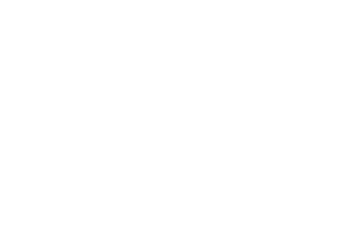

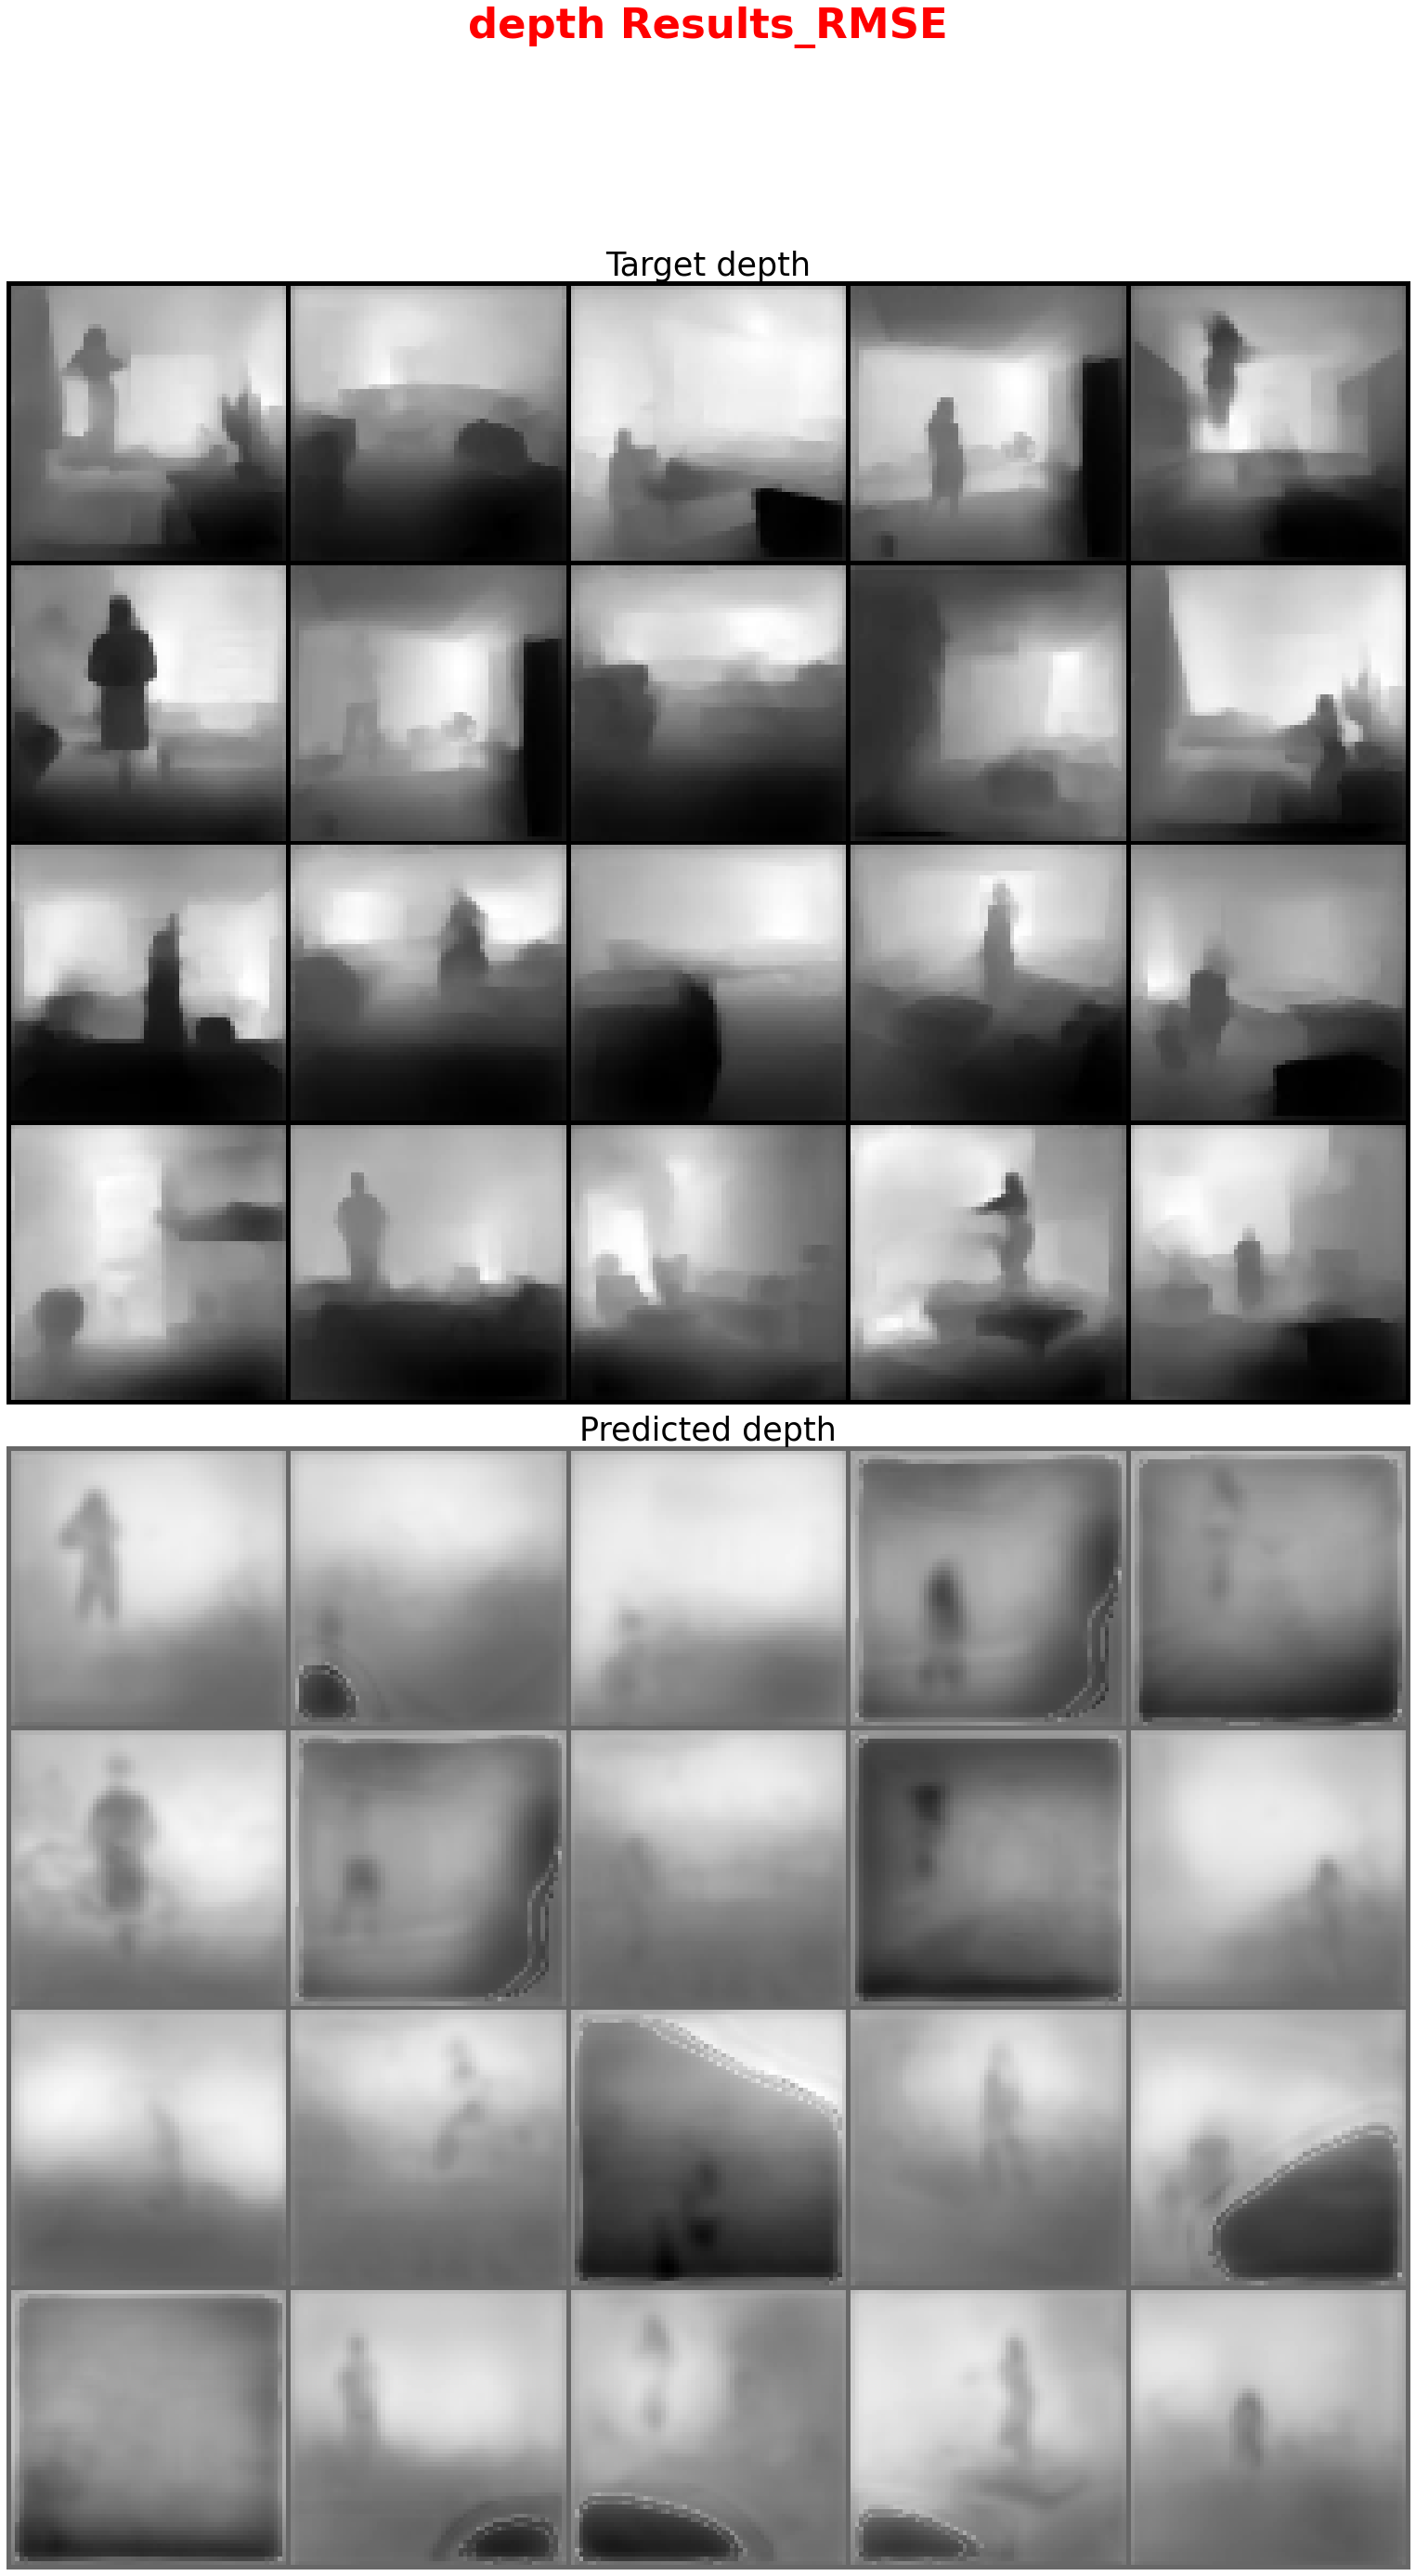

Results are saved in Results_RMSE_ type.jpg


In [0]:
show_results(model,testloader,name = "Results_RMSE")



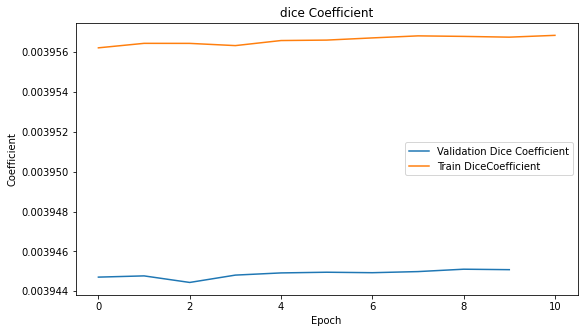

In [0]:
curves = [{"y":test_acc , "label": "Validation Dice Coefficient","xlabel": "Epoch", "ylabel":"Coefficient" },{"y":train_acc , "label": "Train DiceCoefficient","xlabel": "Epoch", "ylabel":"Coefficient" }]
evaluate.plot_curve(curves,"dice Coefficient",Figsize = (9,5))

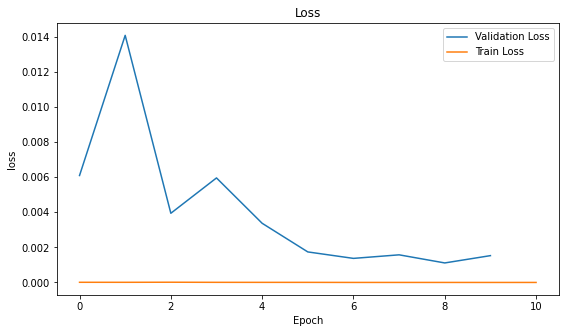

In [0]:
curves = [{"y":test_losses , "label": "Validation Loss","xlabel": "Epoch", "ylabel":"Loss" },{"y":train_losses , "label": "Train Loss","xlabel": "Epoch", "ylabel":"loss" }]
evaluate.plot_curve(curves,"Loss",Figsize = (9,5))